In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from keras.models import Sequential
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten, Dropout, BatchNormalization, LayerNormalization, TimeDistributed
#from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
import tensorflow as tf
#import talib as ta
from keras import regularizers
from sklearn.metrics import mean_squared_error
#import plotly.graph_objects as go
from matplotlib.gridspec import GridSpec
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import sklearn
#from keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GBP_USD_M15.csv')
df.head()

,Unnamed: 0,datetime,open,high,low,close,volume
0,0,2005-01-02T19:15:00.000000000Z,1.9193,1.9193,1.9193,1.9193,1
1,1,2005-01-02T19:30:00.000000000Z,1.9188,1.9197,1.9188,1.9194,11
2,2,2005-01-02T20:00:00.000000000Z,1.9191,1.9197,1.9191,1.9197,2
3,3,2005-01-02T20:30:00.000000000Z,1.9193,1.9197,1.9193,1.9197,2
4,4,2005-01-02T20:45:00.000000000Z,1.9197,1.9197,1.9185,1.9194,36


In [4]:
!python --version    # more help to install taLib  https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib as ta

Python 3.7.13
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3973    0  3973    0     0  20065      0 --:--:-- --:--:-- --:--:-- 20167
100  503k  100  503k    0     0   575k      0 --:--:-- --:--:-- --:--:-- 1912k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3981    0  3981    0     0  25683      0 --:--:-- --:--:-- --:--:-- 25683
100  406k  100  406k    0     0   542k      0 --:--:-- --:--:-- --:--:-- 1489k


In [5]:
def addIndicators(df):

    df['RSI5'] = ta.RSI(df['close'], timeperiod=5)
    df['RSI10'] = ta.RSI(df['close'], timeperiod=10)
    df['RSI20'] = ta.RSI(df['close'], timeperiod=20)

    df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['close'], \
                                                                 fastperiod=12, slowperiod=26, signalperiod=9)

    df['slowk'], df['slowd'] = ta.STOCH(df['high'], df['low'], \
                                            df['close'], fastk_period=5, slowk_period=3, slowk_matype=0,
                                            slowd_period=3, slowd_matype=0)
    df['fastk'], df['fastd'] = ta.STOCHF(df['high'], df['low'], \
                                             df['close'], fastk_period=5, fastd_period=3, fastd_matype=0)

    df['WR5'] = ta.WILLR(df['high'], df['low'], df['close'], timeperiod=5)
    df['WR10'] = ta.WILLR(df['high'], df['low'], df['close'], timeperiod=10)
    df['WR20'] = ta.WILLR(df['high'], df['low'], df['close'], timeperiod=20)

    df['ROC5'] = ta.ROC(df['close'], timeperiod=5)
    df['ROC10'] = ta.ROC(df['close'], timeperiod=10)
    df['ROC20'] = ta.ROC(df['close'], timeperiod=20)

    df['TRANGE'] = ta.TRANGE(df['high'], df['low'], df['close'])
    return df
df = addIndicators(df)

CNN 2D

In [9]:
## Generating price sequence in multidimensions

def price_sequence2d(data,price,num_days):
    
    '''Input: the 'data' for feature set, 'price' variable and 'n_step'  
      'n_step': determines the # historical price point that we want to use to predict following price point in the future
       Output: X: Convert the 'data' into an array of [n_step x 1 x n_feature] dimension 
               y: Convert the price variable into an 1D array
       Example: If y[t] represent today's price point, 
                corresponding X[t] represent 10 historical feature set given n_step =10
    '''
    
    X, y = [], []
    for i in range(len(price)-num_days):
        #e.g. Taking the 8th day as the label if the previous 7 days are features
        y.append(price[i+num_days])
        holder = data[i:(i+num_days)]
        holder = [[j] for j in holder]
        X.append(holder)
        
    return array(X), array(y)

In [12]:
df.head()
num_days = 5

### Using 'macd' indicator

df2 = df[['close','macd']].values
X, y = price_sequence2d(df2,df['close'],num_days)

### Reshaping X for CNN
X_new = X.reshape((X.shape[0], X.shape[1], X.shape[3], X.shape[2])) 

### Replacing Nan with 0
X_new[np.isnan(X_new)] = 0


# X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization

### Split dataset into training and test set
history = int(len(y)*0.8) 
X_train = np.asarray(X_new[:history])
X_test = np.asarray(X_new[history:])
y_train = np.asarray(y[:history])
y_test = np.asarray(y[history:])


print("Shape of X_train: {}".format(np.shape(X_train)))
print("Shape of X_test: {}".format(np.shape(X_test)))
print("Shape of y_train: {}".format(np.shape(y_train)))
print("Shape of y_test: {}".format(np.shape(y_test)))

Shape of X_train: (302802, 5, 2, 1)
Shape of X_test: (75701, 5, 2, 1)
Shape of y_train: (302802,)
Shape of y_test: (75701,)


In [31]:
from tensorflow.keras.optimizers import SGD
input_shape = (( X_train.shape[1], X_train.shape[2],X_train.shape[3]))

# Create the model
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(1, 1), activation='relu', input_shape=input_shape))
cnn_model.add(MaxPooling2D(pool_size=(1,1)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu',  kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.010))
cnn_model.add(Dense(60, activation='relu',  kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dense(1))
sgd = SGD(lr=0.001, nesterov=True, clipnorm=100);
# Compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error')


cnn_model.summary()
print("Input Shape:",input_shape)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 5, 2, 32)          64        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 5, 2, 32)         0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 320)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               41088     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 60)                7740      
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


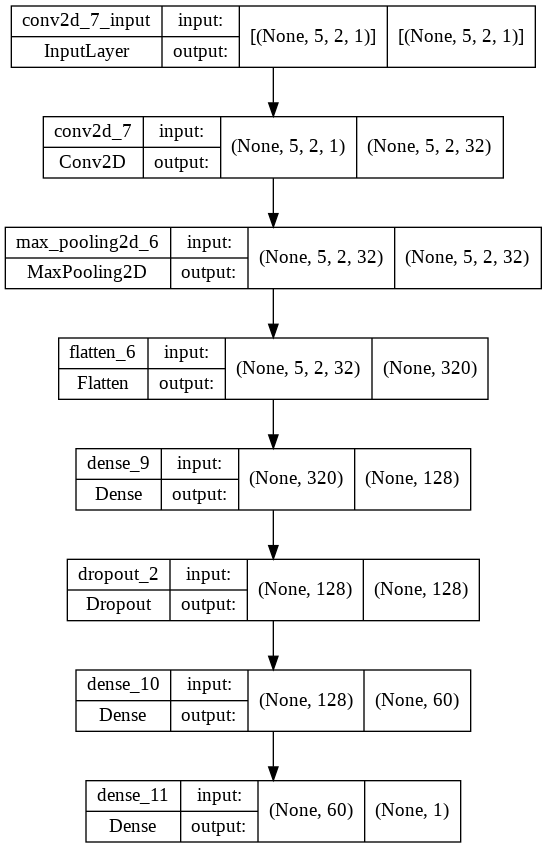

In [32]:
from keras.utils.vis_utils import plot_model
#from keras.utils import plot_model
plot_model(cnn_model, to_file='Functional CNN LSTM 1D.png', show_shapes=True,show_layer_names=True)

In [33]:
# Fit data to model
cnn_model.fit(X_train, y_train,epochs=50,verbose=2,validation_data=(X_test, y_test))
score_macd = cnn_model.evaluate(X_test, y_test, verbose=0)
score_macd

Epoch 1/50
9463/9463 - 28s - loss: 0.0277 - val_loss: 0.0017 - 28s/epoch - 3ms/step
Epoch 2/50
9463/9463 - 22s - loss: 0.0013 - val_loss: 0.0012 - 22s/epoch - 2ms/step
Epoch 3/50
9463/9463 - 22s - loss: 9.5342e-04 - val_loss: 8.1875e-04 - 22s/epoch - 2ms/step
Epoch 4/50
9463/9463 - 25s - loss: 8.3768e-04 - val_loss: 6.5115e-04 - 25s/epoch - 3ms/step
Epoch 5/50
9463/9463 - 22s - loss: 7.7624e-04 - val_loss: 7.3656e-04 - 22s/epoch - 2ms/step
Epoch 6/50
9463/9463 - 23s - loss: 7.2726e-04 - val_loss: 5.7094e-04 - 23s/epoch - 2ms/step
Epoch 7/50
9463/9463 - 22s - loss: 6.8981e-04 - val_loss: 4.8784e-04 - 22s/epoch - 2ms/step
Epoch 8/50
9463/9463 - 23s - loss: 6.6405e-04 - val_loss: 6.2749e-04 - 23s/epoch - 2ms/step
Epoch 9/50
9463/9463 - 22s - loss: 6.2577e-04 - val_loss: 6.1941e-04 - 22s/epoch - 2ms/step
Epoch 10/50
9463/9463 - 25s - loss: 6.0595e-04 - val_loss: 4.9451e-04 - 25s/epoch - 3ms/step
Epoch 11/50
9463/9463 - 22s - loss: 5.8757e-04 - val_loss: 5.1355e-04 - 22s/epoch - 2ms/step
Ep

0.0005632043466903269

In [34]:
predicted = cnn_model.predict(X_test)
p = predicted.flatten() 

from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_test, p, squared=False)
rms
#rmse_macd = rmse(y_test, p)
#rmse_macd

0.019599214081824405

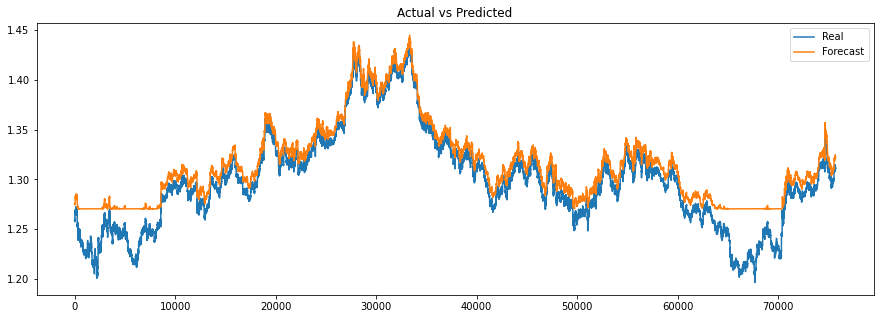

In [35]:
plt.figure(figsize=(15,5))
#plt.plot(range(history),y_train,label='History')
plt.plot(range(len(p)),y_test,label='Real')
plt.plot(range(len(p)),p,label='Forecast')
plt.title('Actual vs Predicted')
plt.legend(loc='best')
plt.show()

LSTM

In [8]:
def data_sequence(data, predict_price, num_days):    #### Data needs to be an array

    X = []
    y = []

    for i in range(num_days, data.shape[0]):
        X.append(data[i-num_days:i])
        y.append(predict_price[i])

    return array(X), array(y)


In [10]:
d = df.copy()
### Dropping irrelevent data
d = d.drop(['datetime','volume'], axis =1)
d.dropna(axis = 0, inplace =True, how = 'any')
d = d.reset_index(drop=True)
np.shape(d)

(378475, 22)

In [11]:
def row_wise_scale(X, y):

    max_of_rows = X.max(axis=1)
    X_scaled = X / max_of_rows[:, np.newaxis]
    y_scaled = y/max_of_rows[:,3]   #### Scaling labels using scaler of close price
    
    return X_scaled, y_scaled, max_of_rows

In [7]:
### Data prep
X,y = data_sequence(array(d), d['close'], 10)
### Scaling
X_scaled, y_scaled, max_of_rows = row_wise_scale(X, y)
### Replacing any missing value with zero
# X_scaled[np.isnan(X_scaled)] = 0
# y_scaled[np.isnan(y_scaled)] = 0

### Split data into train and test
history = int(len(y)*0.8) 
X_train_scaled = np.asarray(X_scaled[:history])
X_test_scaled = np.asarray(X_scaled[history:])
y_train_scaled = np.asarray(y_scaled[:history])
y_test_scaled = np.asarray(y_scaled[history:])


In [8]:
num_days = 5
### Data prep
X,y = data_sequence(array(d), d['close'], num_days)
### Scaling
X_scaled, y_scaled, max_of_rows = row_wise_scale(X, y)

### Replacing any missing value/inf with zero
X_scaled[X_scaled == -np.inf] = 0
X_scaled[X_scaled == np.inf] = 0

y_scaled[y_scaled == -np.inf] = 0
y_scaled[y_scaled == np.inf] = 0

X_scaled[np.isnan(X_scaled)] = 0
y_scaled[np.isnan(y_scaled)] = 0

### Split data into train and test
history = int(len(y)*0.8) 
X_train_scaled = np.asarray(X_scaled[:history])
X_test_scaled = np.asarray(X_scaled[history:])
y_train_scaled = np.asarray(y_scaled[:history])
y_test_scaled = np.asarray(y_scaled[history:])

### Keeping track of the scalar for inverting
train_scale = np.asarray(max_of_rows[:,3][:history])
test_scale = np.asarray(max_of_rows[:,3][history:])


print("Shape of X_train: {}".format(np.shape(X_train_scaled)))
print("Shape of X_test: {}".format(np.shape(X_test_scaled)))
print("Shape of y_train_scaled: {}".format(np.shape(y_train_scaled)))
print("Shape of y_train_scaled: {}".format(np.shape(y_test_scaled)))



Shape of X_train: (302802, 5, 5)
Shape of X_test: (75701, 5, 5)
Shape of y_train_scaled: (302802,)
Shape of y_train_scaled: (75701,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                640       
                                                                 
 dense (Dense)               (None, 50)                550       
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 70)                3570      
                                                                 
 dense_2 (Dense)             (None, 50)                3550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                1

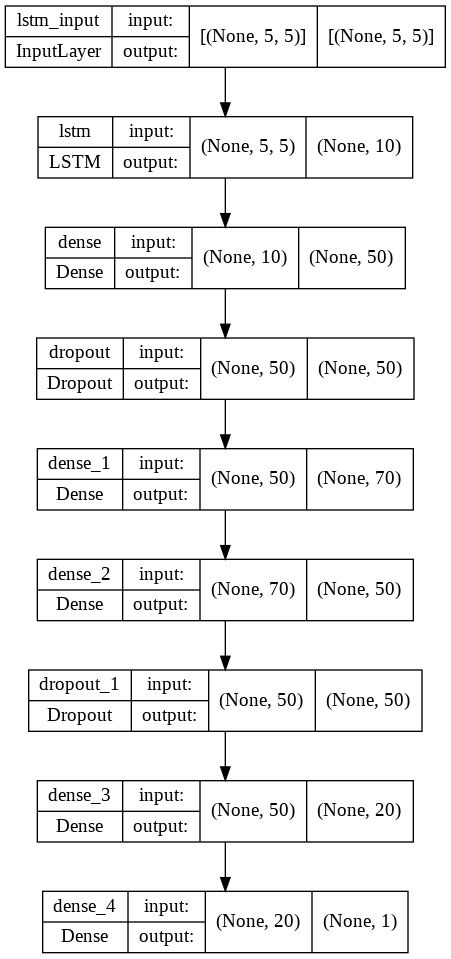

In [9]:

#### Training the model

lstm_model = Sequential()
lstm_model.add(LSTM(10,input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
lstm_model.add(Dense(50,activation = 'relu'))
lstm_model.add(Dropout(0.050))
lstm_model.add(Dense(70,activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
lstm_model.add(Dense(50,activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
lstm_model.add(Dropout(0.050))
lstm_model.add(Dense(20,activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
lstm_model.add(Dense(1,activation = 'linear'))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.summary()



from keras.utils.vis_utils import plot_model
#from keras.utils import plot_model
plot_model(lstm_model, to_file='Functional CNN LSTM 1D.png', show_shapes=True,show_layer_names=True)




In [10]:
#### Fitting Trained model

lstm_model.fit(X_train_scaled, y_train_scaled, epochs=30, verbose=2, validation_data=(X_test_scaled, y_test_scaled))


Epoch 1/30
9463/9463 - 54s - loss: 0.0173 - val_loss: 8.8007e-07 - 54s/epoch - 6ms/step
Epoch 2/30
9463/9463 - 44s - loss: 1.6707e-06 - val_loss: 1.1139e-06 - 44s/epoch - 5ms/step
Epoch 3/30
9463/9463 - 45s - loss: 1.5895e-06 - val_loss: 1.4994e-06 - 45s/epoch - 5ms/step
Epoch 4/30
9463/9463 - 43s - loss: 1.5824e-06 - val_loss: 1.1201e-06 - 43s/epoch - 5ms/step
Epoch 5/30
9463/9463 - 44s - loss: 1.5744e-06 - val_loss: 1.3577e-06 - 44s/epoch - 5ms/step
Epoch 6/30
9463/9463 - 45s - loss: 1.5676e-06 - val_loss: 1.3820e-06 - 45s/epoch - 5ms/step
Epoch 7/30
9463/9463 - 44s - loss: 1.5885e-06 - val_loss: 1.5943e-06 - 44s/epoch - 5ms/step
Epoch 8/30
9463/9463 - 44s - loss: 1.5782e-06 - val_loss: 1.1836e-06 - 44s/epoch - 5ms/step
Epoch 9/30
9463/9463 - 42s - loss: 1.5694e-06 - val_loss: 1.0303e-06 - 42s/epoch - 4ms/step
Epoch 10/30
9463/9463 - 42s - loss: 1.5704e-06 - val_loss: 9.7994e-07 - 42s/epoch - 4ms/step
Epoch 11/30
9463/9463 - 43s - loss: 1.5772e-06 - val_loss: 1.9988e-06 - 43s/epoch -

In [ ]:
#### Model Prediction
import numpy

pred= lstm_model.predict(X_test_scaled)


print("Root Mean Square:" ,numpy.round(pred,2))

## Inverting scaling
pred2 = pred * test_scale
y_test2 = y_test_scaled * test_scale
y_train2 = y_train_scaled * train_scale

rmse_lstm_mv = mean_squared_error(y_test2, pred2, squared=False)

print("Root Mean Square:" ,numpy.round(rmse_lstm_mv,2))

#plt.figure(figsize=(15,5))
#plt.plot(range(num_days,history),y_train2,label='History')
#plt.plot(range(history,history+len(pred)),y_test,label='Real')
#plt.plot(range(history,history+len(pred)),pred,label='Forecast')
#plt.title('Actual vs Predicted')
#plt.legend(loc='best')
#plt.show()

Root Mean Square: [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


GRU

In [12]:
### Data prep
X,y = data_sequence(array(d), d['close'], 10)
### Scaling
X_scaled, y_scaled, max_of_rows = row_wise_scale(X, y)

### Replacing any missing value/inf with zero
X_scaled[X_scaled == -np.inf] = 0
X_scaled[X_scaled == np.inf] = 0

y_scaled[y_scaled == -np.inf] = 0
y_scaled[y_scaled == np.inf] = 0

X_scaled[np.isnan(X_scaled)] = 0
y_scaled[np.isnan(y_scaled)] = 0

### Split data into train and test
history = int(len(y)*0.8) 
X_train_scaled = np.asarray(X_scaled[:history])
X_test_scaled = np.asarray(X_scaled[history:])
y_train_scaled = np.asarray(y_scaled[:history])
y_test_scaled = np.asarray(y_scaled[history:] )

### Keeping track of the scalar for inverting
train_scale = np.asarray(max_of_rows[:,3][:history])
test_scale = np.asarray(max_of_rows[:,3][history:])


print("Shape of X_train: {}".format(np.shape(X_train_scaled)))
print("Shape of X_test: {}".format(np.shape(X_test_scaled)))
print("Shape of y_train_scaled: {}".format(np.shape(y_train_scaled)))
print("Shape of y_train_scaled: {}".format(np.shape(y_test_scaled)))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Shape of X_train: (302772, 10, 22)
Shape of X_test: (75693, 10, 22)
Shape of y_train_scaled: (302772,)
Shape of y_train_scaled: (75693,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10)                1020      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 1,031
Trainable params: 1,031
Non-trainable params: 0
_________________________________________________________________


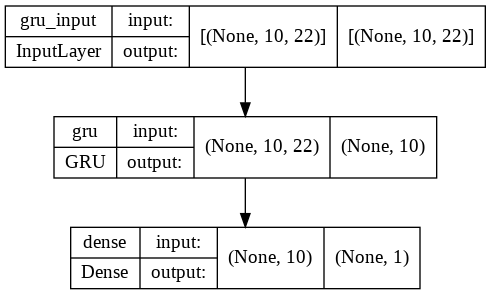

In [13]:


#### Training the model

from keras.layers import GRU

gru_model = Sequential()
gru_model.add(GRU(10,input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.summary()

from keras.utils.vis_utils import plot_model
#from keras.utils import plot_model
plot_model(gru_model, to_file='Functional CNN LSTM 1D.png', show_shapes=True,show_layer_names=True)

In [16]:
#### Fitting Trained model

gru_model.fit(X_train_scaled, y_train_scaled, epochs=30, verbose=2, validation_data=(X_test_scaled, y_test_scaled))



Epoch 1/30
9462/9462 - 53s - loss: 0.0064 - val_loss: 1.0033e-04 - 53s/epoch - 6ms/step
Epoch 2/30
9462/9462 - 46s - loss: 3.4416e-05 - val_loss: 5.9604e-06 - 46s/epoch - 5ms/step
Epoch 3/30
9462/9462 - 47s - loss: 9.8873e-06 - val_loss: 2.5459e-06 - 47s/epoch - 5ms/step
Epoch 4/30
9462/9462 - 47s - loss: 8.5915e-06 - val_loss: 1.6254e-06 - 47s/epoch - 5ms/step
Epoch 5/30
9462/9462 - 47s - loss: 3.0613e-06 - val_loss: 2.0492e-06 - 47s/epoch - 5ms/step
Epoch 6/30
9462/9462 - 46s - loss: 2.4165e-06 - val_loss: 1.0735e-06 - 46s/epoch - 5ms/step
Epoch 7/30
9462/9462 - 47s - loss: 2.1319e-06 - val_loss: 2.4024e-06 - 47s/epoch - 5ms/step
Epoch 8/30
9462/9462 - 48s - loss: 1.9130e-06 - val_loss: 1.1902e-06 - 48s/epoch - 5ms/step
Epoch 9/30
9462/9462 - 48s - loss: 1.7987e-06 - val_loss: 2.2794e-06 - 48s/epoch - 5ms/step
Epoch 10/30
9462/9462 - 47s - loss: 1.7802e-06 - val_loss: 7.7508e-07 - 47s/epoch - 5ms/step
Epoch 11/30
9462/9462 - 48s - loss: 1.6815e-06 - val_loss: 1.2373e-06 - 48s/epoch -

NameError: ignored

Root Mean Square: 0.0


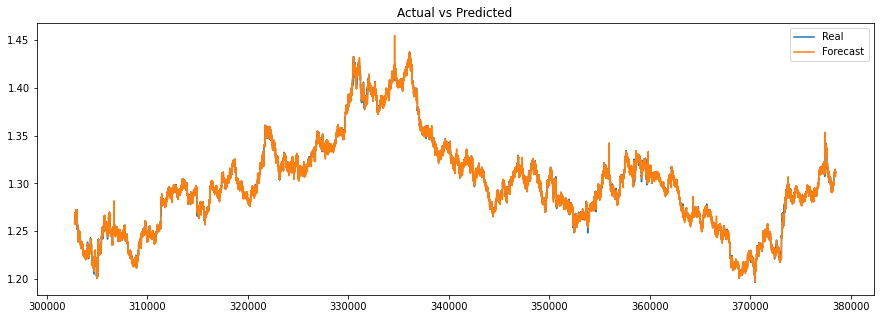

In [17]:
### Model Prediction

pred= gru_model.predict(X_test_scaled)
pred = pred.flatten() 

## Inverting scaling
pred2 = pred * test_scale
y_test2 = y_test_scaled * test_scale
y_train2 = y_train_scaled * train_scale

rmse_gru_mv = mean_squared_error(y_test2, pred2, squared=False)

print("Root Mean Square:" ,round(rmse_gru_mv,2))

plt.figure(figsize=(15,5))
#plt.plot(range(num_days,history),y_train2,label='History')
plt.plot(range(history,history+len(pred)),y_test2,label='Real')
plt.plot(range(history,history+len(pred)),pred2,label='Forecast')
plt.title('Actual vs Predicted')
plt.legend(loc='best')
plt.show()